In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.16:40339 Dashboard: http://10.148.1.16:8787/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


---


# 1. Drifter 

## （ 1. all drifters, 2. drogued drifters, 3. undrogued drifters）

#### $KE = u^2 + v^2$

In [5]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1
# mdpth: mean water depth,               157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v)                            157978*1440
# dpth2:                                 157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [7]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 157978)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [10]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 157978)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [11]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 157978)>
array([ -193.07666 ,   -78.65568 ,  -800.508745, ..., -4722.161599,
       -4633.789814, -4684.155683])
Dimensions without coordinates: mdpth

In [12]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [13]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [14]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
    qu           (lat) uint8 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 ...
    qmed200      (lat) uint8 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.2856 0.3275 0.3241 0.2902 0.1315 ...
    depth        (lat, time) float64 -1.642e+03 -1.6e+03 -1.567e+03 ...

 data size: 3.6 GB


## 1.2. KE

In [15]:
KE_drifters_qd = ds.KE_drifters.where((ds.qd==1) & (ds.depth<-500)).mean(dim=['time'])
KE_drifters_qd = np.real(KE_drifters_qd).rename('KE_drifters_qd')

KE_drifters_qu = ds.KE_drifters.where((ds.qu==1) & (ds.depth<-500)).mean(dim=['time'])
KE_drifters_qu = np.real(KE_drifters_qu).rename('KE_drifters_qu')

KE_drifters_all = ds.KE_drifters.where(ds.depth<-500).mean(dim=['time'])
KE_drifters_all = np.real(KE_drifters_all).rename('KE_drifters_all')

In [16]:
E_drifters_qd = KE_drifters_qd.groupby_bins(KE_drifters_qd.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd = E_drifters_qd.load()

E_drifters_qu = KE_drifters_qu.groupby_bins(KE_drifters_qu.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu = E_drifters_qu.load()

E_drifters_all = KE_drifters_all.groupby_bins(KE_drifters_all.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all = E_drifters_all.load()

Text(0.5,1,'Drifters')

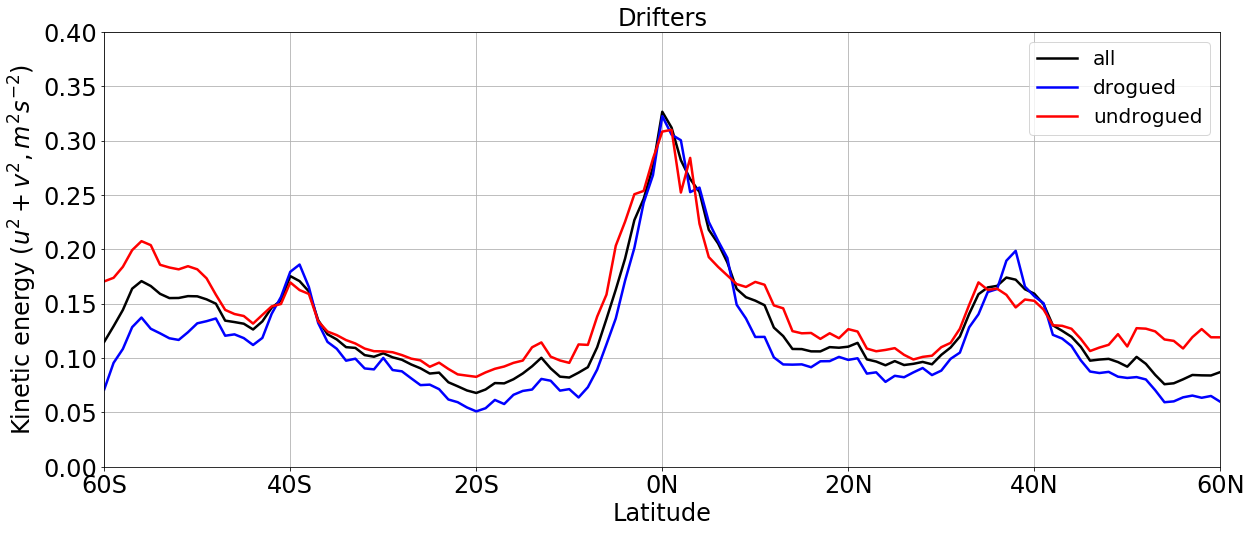

In [17]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


_______________
# 2. GPS-tracked drifters 

#### $KE = u^2 + v^2$

In [19]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_GPS.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     25008*1
# mlon2: mean longitude over 60 days,    25008*1
# mdpth: mean water depth,               25008*1

# qd: drogued drifters,                  25008*1
# qmed200: median water depth > 200 m,   25008*1
# qu: undrogued drifters,                25008*1

# uv2: (u, v)                            25008*1440
# dpth2:                                 25008*1440

[('dpth2', <HDF5 dataset "dpth2": shape (25008, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (25008, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (25008, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (25008, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (25008, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (25008, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (25008, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (25008, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (25008, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (25008, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (25008, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (25008, 1), type "|u1">),
 ('uv2', <HDF5 dataset "uv2": shape (25008, 1440), type "|V16">)]

In [20]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 25008)>
array([  2.851229,   1.022867,  -1.890194, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [21]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 25008)>
array([267.180947, 258.853496, 249.391945, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [22]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 25008)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [23]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 25008)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [24]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 25008)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [25]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 25008)>
array([-2481.856058, -3236.531319, -3926.650875, ..., -4722.161599,
       -4633.789814, -4684.155683])
Dimensions without coordinates: mdpth

In [26]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((25008, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [27]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [28]:
# Drifter Dataset (u+iv,lat,qd,time)
ds_GPS = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds_GPS)
print('\n data size: %.1f GB' %(ds_GPS.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 25008, time: 1440)
Coordinates:
  * lat          (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 24.73 ...
    lon          (lat) float64 267.2 258.9 249.4 320.8 319.6 318.0 318.0 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    qu           (lat) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    qmed200      (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.005215 0.009021 0.006992 0.005334 ...
    depth        (lat, time) float64 -2.571e+03 -2.574e+03 -2.578e+03 ...

 data size: 0.6 GB


## 2.2. KE

In [58]:
KE_drifters_qd_GPS = ds_GPS.KE_drifters.where((ds_GPS.qd==1) & (ds_GPS.depth<-500)).mean(dim=['time'])
KE_drifters_qd_GPS = np.real(KE_drifters_qd_GPS).rename('KE_drifters_qd_GPS')

KE_drifters_qu_GPS = ds_GPS.KE_drifters.where((ds_GPS.qu==1) & (ds_GPS.depth<-500)).mean(dim=['time'])
KE_drifters_qu_GPS = np.real(KE_drifters_qu_GPS).rename('KE_drifters_qu_GPS')

KE_drifters_all_GPS = ds_GPS.KE_drifters.where(ds_GPS.depth<-500).mean(dim=['time'])
KE_drifters_all_GPS = np.real(KE_drifters_all_GPS).rename('KE_drifters_all_GPS')

In [63]:
E_drifters_qd_GPS = KE_drifters_qd_GPS.groupby_bins(KE_drifters_qd_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd_GPS = E_drifters_qd_GPS.load()

E_drifters_qu_GPS = KE_drifters_qu_GPS.groupby_bins(KE_drifters_qu_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu_GPS = E_drifters_qu_GPS.load()

E_drifters_all_GPS = KE_drifters_all_GPS.groupby_bins(KE_drifters_all_GPS.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all_GPS = E_drifters_all_GPS.load()

Text(0.5,1,'Drifters')

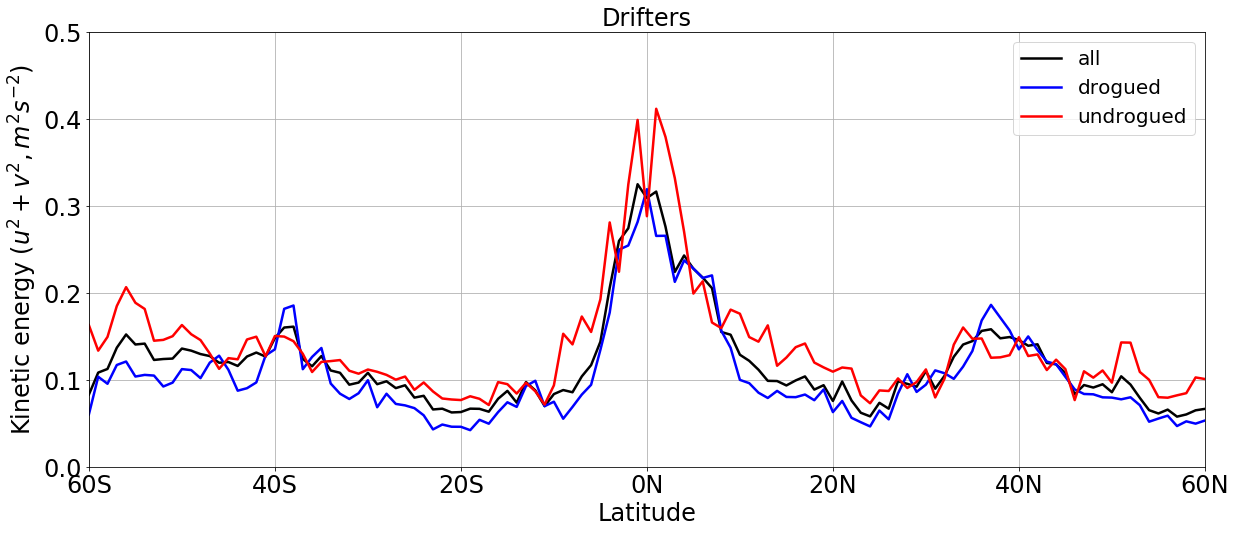

In [64]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all_GPS.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd_GPS.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu_GPS.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.5])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


_______________
# 3. Argos-tracked drifters 

#### $KE = u^2 + v^2$

In [66]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_Argos.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     25008*1
# mlon2: mean longitude over 60 days,    25008*1
# mdpth: mean water depth,               25008*1

# qd: drogued drifters,                  25008*1
# qmed200: median water depth > 200 m,   25008*1
# qu: undrogued drifters,                25008*1

# uv2: (u, v)                            25008*1440
# dpth2:                                 25008*1440

[('dpth2', <HDF5 dataset "dpth2": shape (132970, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (132970, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (132970, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (132970, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (132970, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (132970, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (132970, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (132970, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (132970, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (132970, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (132970, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (132970, 1), type "|u1">),
 ('uv2', <HDF5 dataset "uv2": shape (132970, 1440), type "|V16">)]

In [67]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 132970)>
array([ 44.219853,  44.908928,  44.856863, ..., -12.761236, -12.266537,
       -12.920261])
Dimensions without coordinates: lat

In [68]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 132970)>
array([307.992707, 306.962722, 305.597501, ..., 186.569928, 185.446468,
       183.725235])
Dimensions without coordinates: lon

In [69]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 132970)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [70]:
# turn undrogued_information into xarray_DataArray
qu = drifter_dataset['qu']
qu = np.array(qu)
qu = xr.DataArray(qu, dims=['qu', 'none'])
qu = xr.DataArray.squeeze(qu, dim='none')
qu = np.real(qu).rename('qu')
qu

<xarray.DataArray 'qu' (qu: 132970)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Dimensions without coordinates: qu

In [71]:
qmed200 = drifter_dataset['qmed200']
qmed200 = np.array(qmed200)
qmed200 = xr.DataArray(qmed200, dims=['qmed200', 'none'])
qmed200 = xr.DataArray.squeeze(qmed200, dim='none')
qmed200 = np.real(qmed200).rename('qmed200')
qmed200

<xarray.DataArray 'qmed200' (qmed200: 132970)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qmed200

In [72]:
mdpth = drifter_dataset['mdpth']
mdpth = np.array(mdpth)
mdpth = xr.DataArray(mdpth, dims=['mdpth', 'none'])
mdpth = xr.DataArray.squeeze(mdpth, dim='none')
mdpth = np.real(mdpth).rename('mdpth')
mdpth

<xarray.DataArray 'mdpth' (mdpth: 132970)>
array([ -193.07666 ,   -78.65568 ,  -800.508745, ..., -4274.524006,
       -4004.953812, -3221.885254])
Dimensions without coordinates: mdpth

In [73]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((132970, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

KE_drifters = (u_drifters**2 + v_drifters**2)

In [74]:
depth = drifter_dataset['dpth2']
depth = np.array(depth)

In [75]:
# Drifter Dataset (u+iv,lat,qd,time)
ds_Argos = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters),
                'depth': (['lat','time'],depth)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd),
                         'qu':(['lat'],qu),
                         'qmed200':(['lat'],qmed200)})
print(ds_GPS)
print('\n data size: %.1f GB' %(ds_GPS.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 25008, time: 1440)
Coordinates:
  * lat          (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 24.73 ...
    lon          (lat) float64 267.2 258.9 249.4 320.8 319.6 318.0 318.0 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    qu           (lat) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    qmed200      (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    KE_drifters  (lat, time) float64 0.005215 0.009021 0.006992 0.005334 ...
    depth        (lat, time) float64 -2.571e+03 -2.574e+03 -2.578e+03 ...

 data size: 0.6 GB


## 2.2. KE

In [76]:
KE_drifters_qd_Argos = ds_Argos.KE_drifters.where((ds_Argos.qd==1) & (ds_Argos.depth<-500)).mean(dim=['time'])
KE_drifters_qd_Argos = np.real(KE_drifters_qd_Argos).rename('KE_drifters_qd_Argos')

KE_drifters_qu_Argos = ds_Argos.KE_drifters.where((ds_Argos.qu==1) & (ds_Argos.depth<-500)).mean(dim=['time'])
KE_drifters_qu_Argos = np.real(KE_drifters_qu_Argos).rename('KE_drifters_qu_Argos')

KE_drifters_all_Argos = ds_Argos.KE_drifters.where(ds_Argos.depth<-500).mean(dim=['time'])
KE_drifters_all_Argos = np.real(KE_drifters_all_Argos).rename('KE_drifters_all_Argos')

In [77]:
E_drifters_qd_Argos = KE_drifters_qd_Argos.groupby_bins(KE_drifters_qd_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qd_Argos = E_drifters_qd_Argos.load()

E_drifters_qu_Argos = KE_drifters_qu_Argos.groupby_bins(KE_drifters_qu_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_qu_Argos = E_drifters_qu_Argos.load()

E_drifters_all_Argos = KE_drifters_all_Argos.groupby_bins(KE_drifters_all_Argos.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_drifters_all_Argos = E_drifters_all_Argos.load()

Text(0.5,1,'Drifters')

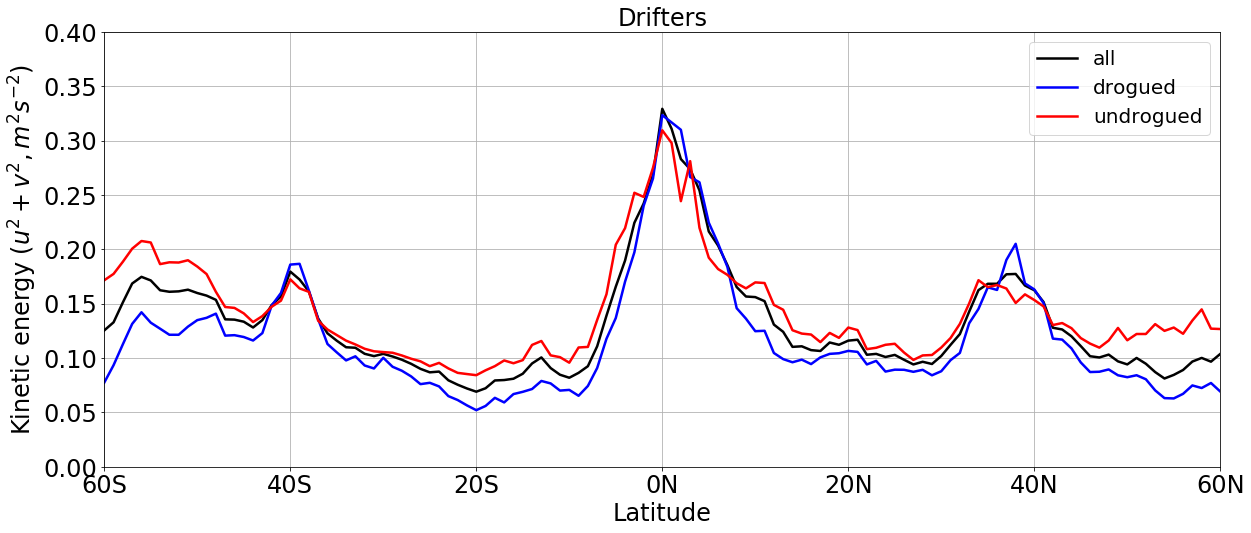

In [79]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all_Argos.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd_Argos.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu_Argos.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


# Comparison

Text(0.5,1,'Drifters')

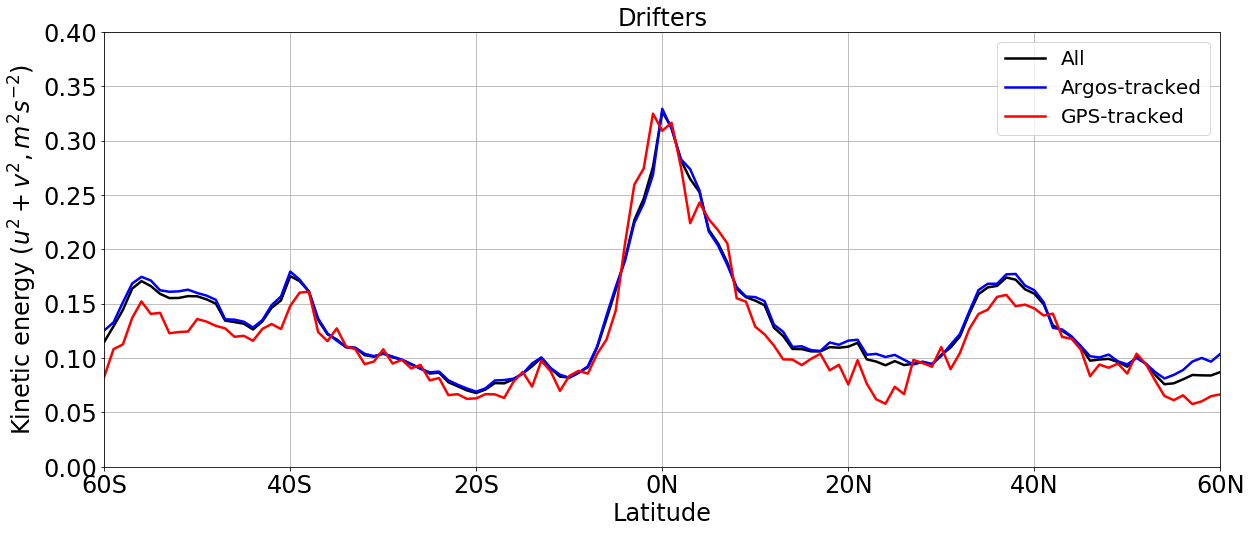

In [83]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['All','Argos-tracked','GPS-tracked']

E_drifters_all.plot(color='black', label=labels[0], linewidth=2.5)
E_drifters_all_Argos.plot(color='blue', label=labels[1], linewidth=2.5)
E_drifters_all_GPS.plot(color='red', label=labels[2], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


Text(0.5,1,'Drifters')

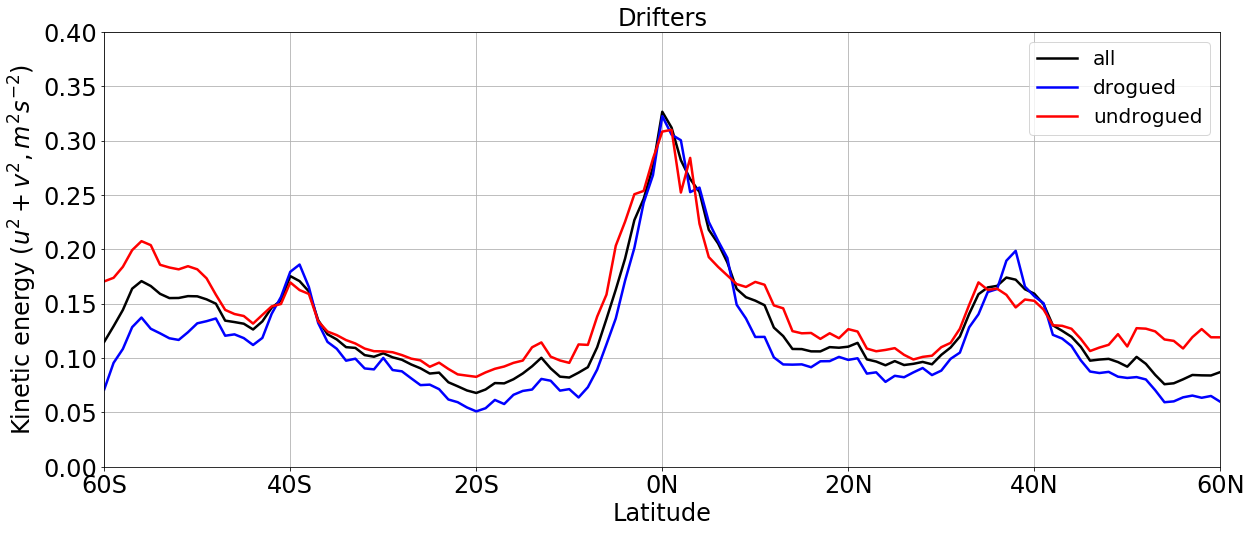

In [17]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['drogued', 'undrogued', 'all']

E_drifters_all.plot(color='black', label=labels[2], linewidth=2.5)
E_drifters_qd.plot(color='blue', label=labels[0], linewidth=2.5)
E_drifters_qu.plot(color='red', label=labels[1], linewidth=2.5)

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Drifter_KE_comparison.png')


In [87]:
cluster.scheduler.close()

<Future finished result=None>